In [1]:
import os, cv2, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
os.chdir('../placas-dataset/caracteres-placas/')
IMAGES = []
for files in os.listdir():
    tmp = cv2.cvtColor(cv2.imread(files), cv2.COLOR_BGR2GRAY)/255
    IMAGES.append((tmp, files[0]))

MIN = min(map(lambda x: min(x[0].shape), IMAGES))
img_shape = (MIN, MIN)
img_size_flat = MIN**2
data = [(cv2.resize(x[0], dsize=(MIN, MIN), interpolation=cv2.INTER_CUBIC), x[1]) for x in IMAGES]

In [3]:
class_names = sorted(list(set([x[1] for x in data])))
num_classes = len(class_names)
onehot = {}
for i, j in enumerate(class_names):
    onehot[j] = np.eye(num_classes, dtype=float)[i]

In [4]:
def helper(part):
    x = []
    y = []
    y_cls = []
    for i in part:
        x.append(i[0].flatten())
        y_cls.append(class_names.index(i[1]))
        y.append(onehot[i[1]])
    x, y, y_cls = np.array(x), np.array(y), np.array(y_cls) 
    return x, y, y_cls

In [41]:
def plot_images(images, cls_pred=None):
    fig, axes = plt.subplots(2, 2)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i][0].reshape(img_shape), cmap='binary')
        if cls_pred is None:
            xlabel = "True: {0}".format(images[i][1])
        else:
            xlabel = "True: {0}, Pred: {1}".format(images[i][1], cls_pred[i])

        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

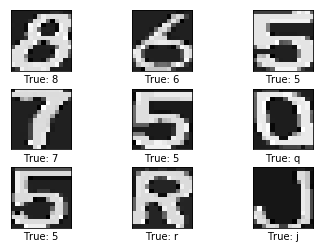

In [6]:
plot_images(data[0:10])

In [7]:
train_por = 0.75
num_train = int(0.75 * len(data))
random.shuffle(data)
train = data[:num_train]
test = data[num_train:]
x_train, y_train, y_train_cls = helper(train)
x_test, y_test, y_test_cls = helper(test)

In [8]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])

In [9]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))
biases = tf.Variable(tf.zeros([num_classes]))

In [10]:
logits = tf.matmul(x, weights) + biases
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, axis=1)

In [11]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                           labels=y_true)
cost = tf.reduce_mean(cross_entropy)

In [12]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

In [13]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [14]:
session = tf.Session()
session.run(tf.global_variables_initializer())
batch_size = 25

In [15]:
def optimize(num_iterations):

    for i in range(num_iterations):
        idx = np.random.randint(low=0, high=num_train, size=batch_size)
        x_batch = x_train[idx]
        y_batch = y_train[idx]
        y_batch_cls = y_train_cls[idx]
        
        feed_dict_train = {x: x_batch,
                           y_true: y_batch}
        session.run(optimizer, feed_dict=feed_dict_train)

In [16]:
feed_dict_test = {x: x_test,
                  y_true: y_test,
                  y_true_cls: y_test_cls}

In [17]:
def print_accuracy():
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print("Accuracy on test-set: {0:.1%}".format(acc))

In [19]:
optimize(num_iterations=100)
print_accuracy()

Accuracy on test-set: 97.1%


In [22]:
def print_confusion_matrix():
    from sklearn.metrics import confusion_matrix
    cls_true = y_test_cls
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    #print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    plt.show()

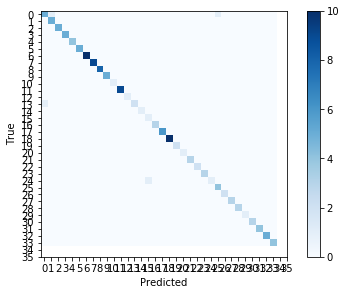

In [23]:
print_confusion_matrix()

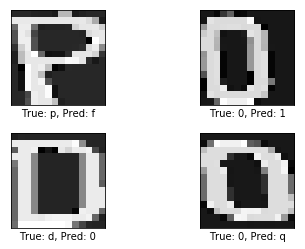

In [43]:
correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                feed_dict=feed_dict_test)

incorrect = (correct == False)
images = x_test[incorrect]
cls_pred = cls_pred[incorrect]
cls_true = y_test_cls[incorrect]
    
# plot the first 9 images.
tmp = list(zip(images, list(map(lambda x: class_names[x], cls_true))))
plot_images(tmp, list(map(lambda x: class_names[x], cls_pred)))